In [2]:
from matplotlib.rcsetup import cycler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import const as CONST
from utils import read_csv_ts, robust_pct
from darts import TimeSeries
import matplotlib
from datasets import SeqDataset, Datasets, DatasetAccesor, DatasetTransformer, load_datasets
import sys
import seaborn as sns

plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [3]:
ds = load_datasets()

INFO:Dataset:Loading dataset from data/preprocessed/datasets.pkl


In [ ]:
print(f"Data starts: {ds.original.series[0].start_time()}")
print(f"Data ends: {ds.original.series[0].end_time()}, len = {len(ds.original.series[0])}")
print(f"Train data starts: {ds.original.train[0].start_time()}, len = {len(ds.original.train[0])}")
print(f"Validation data starts: {ds.original.val[0].start_time()}, len = {len(ds.original.val[0])}")
print(f"Test data starts: {ds.original.test[0].start_time()}, len = {len(ds.original.test[0])}")

Data starts: 2008-01-02 09:00:00
Data ends: 2023-03-09 16:00:00, len = 30584
Validation data starts: 2020-02-26 12:00:00, len = 3058
Test data starts: 2021-08-31 14:00:00, len = 3059


['AEM', 'AUY', 'GFI', 'HMY', 'IAG', 'KGC', 'NEM', 'PAAS']


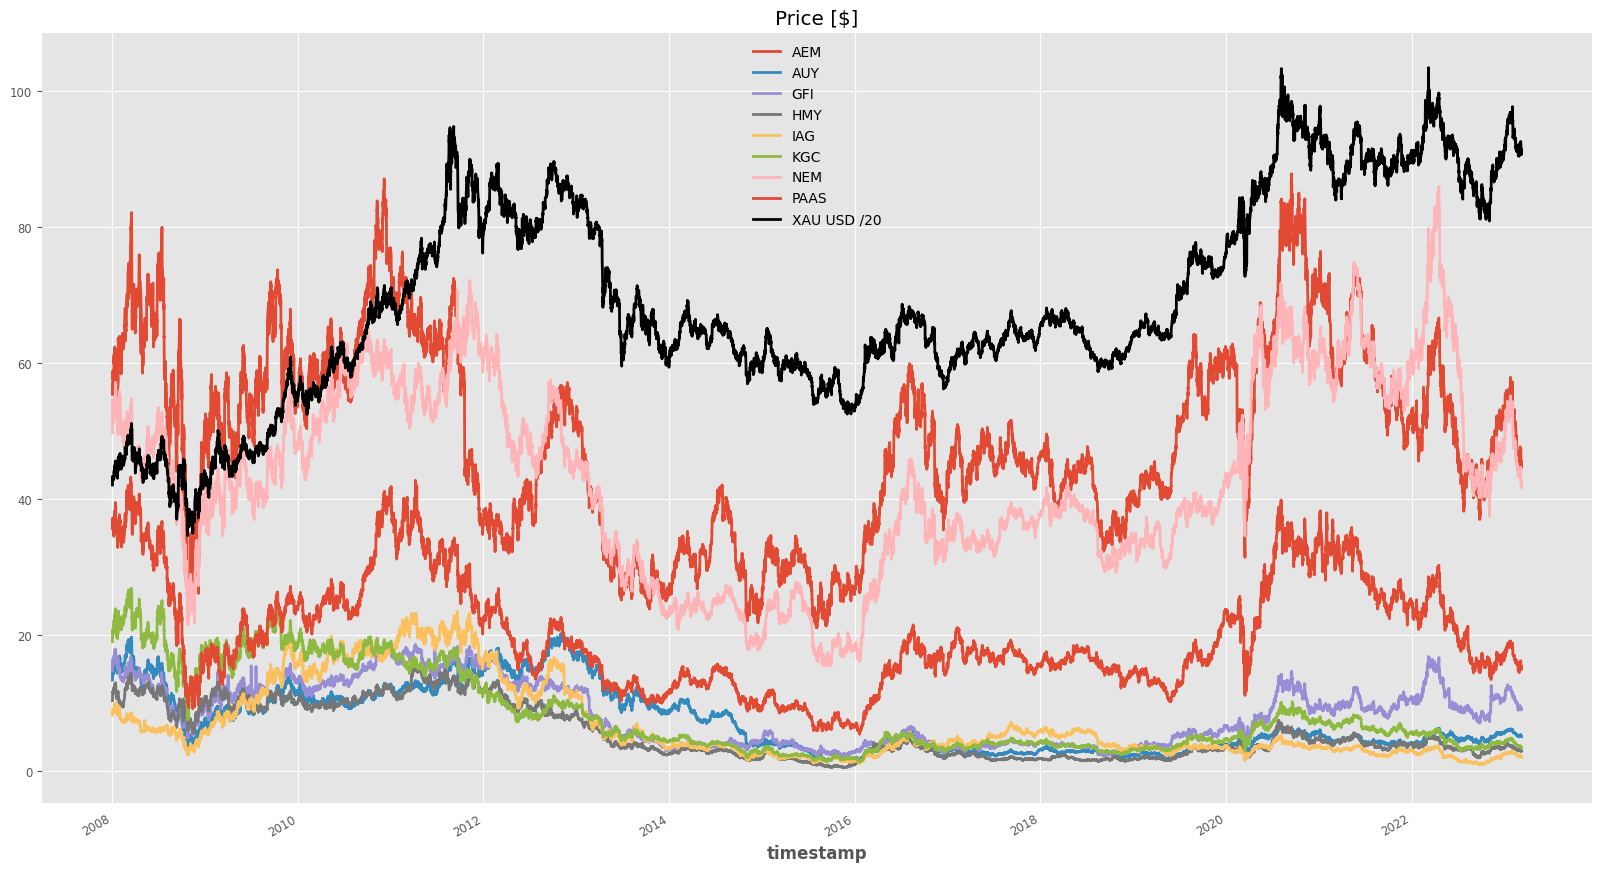

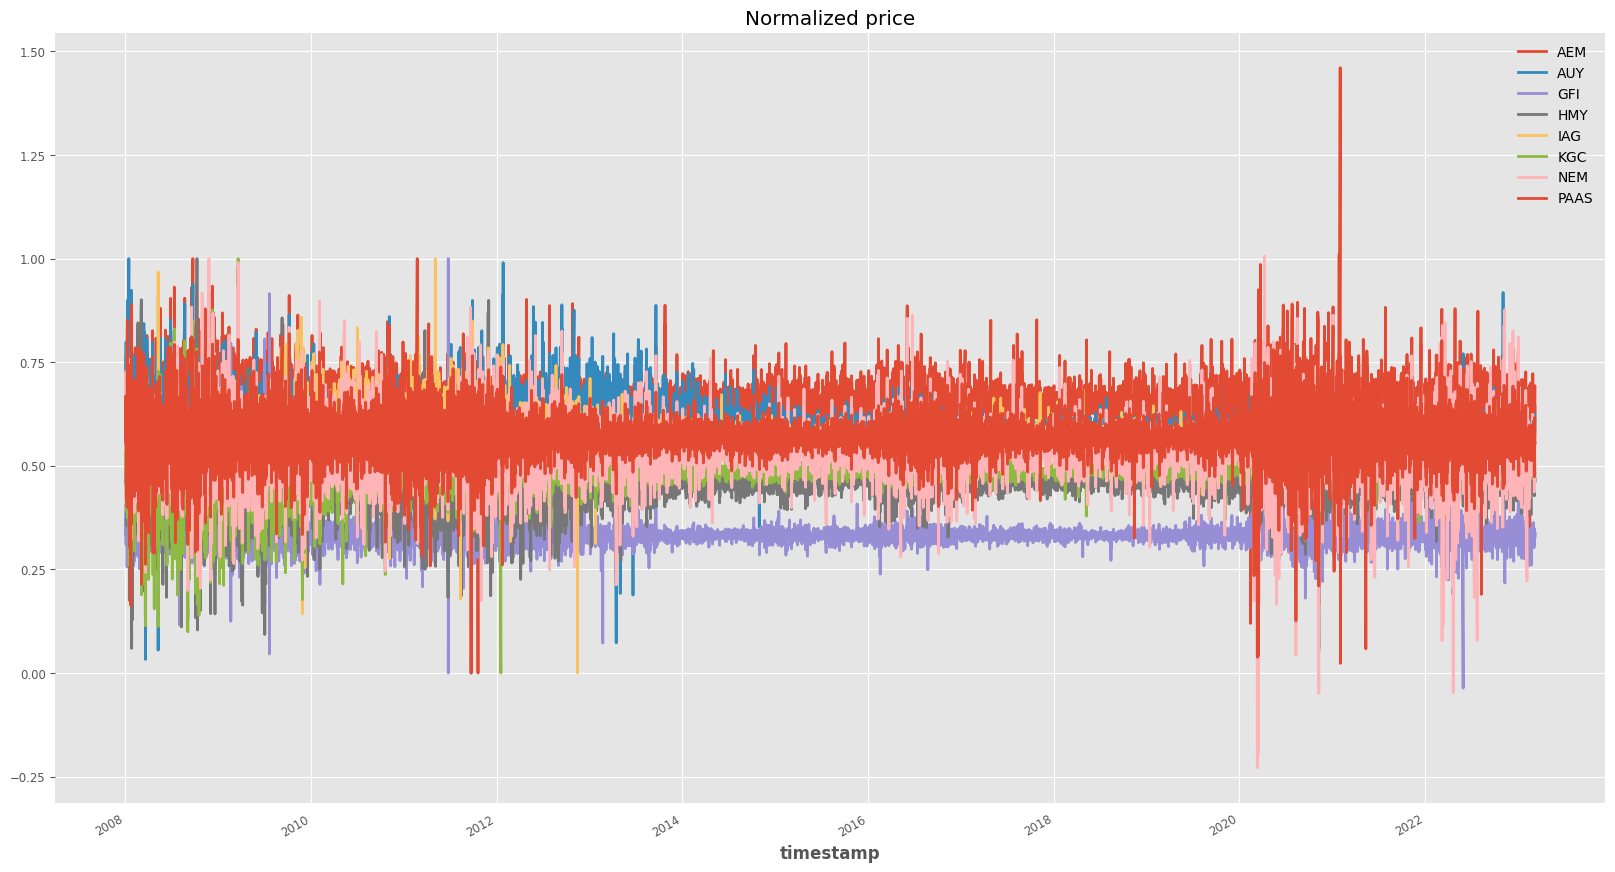

In [4]:
print(ds.original.used_tickers)

for idx,ticker in enumerate(ds.original.used_tickers):
    ds.original.series[idx].plot(label=ticker)

ts = read_csv_ts("data/merged/gold.csv")
TimeSeries.from_dataframe(ts/20).plot(label="XAU USD /20", color="black")
plt.title("Price [$]")
plt.show()


for idx,ticker in enumerate(ds.original.used_tickers):
    ds.transformed.series[idx].plot(label=ticker)

plt.title("Normalized price")
plt.show()

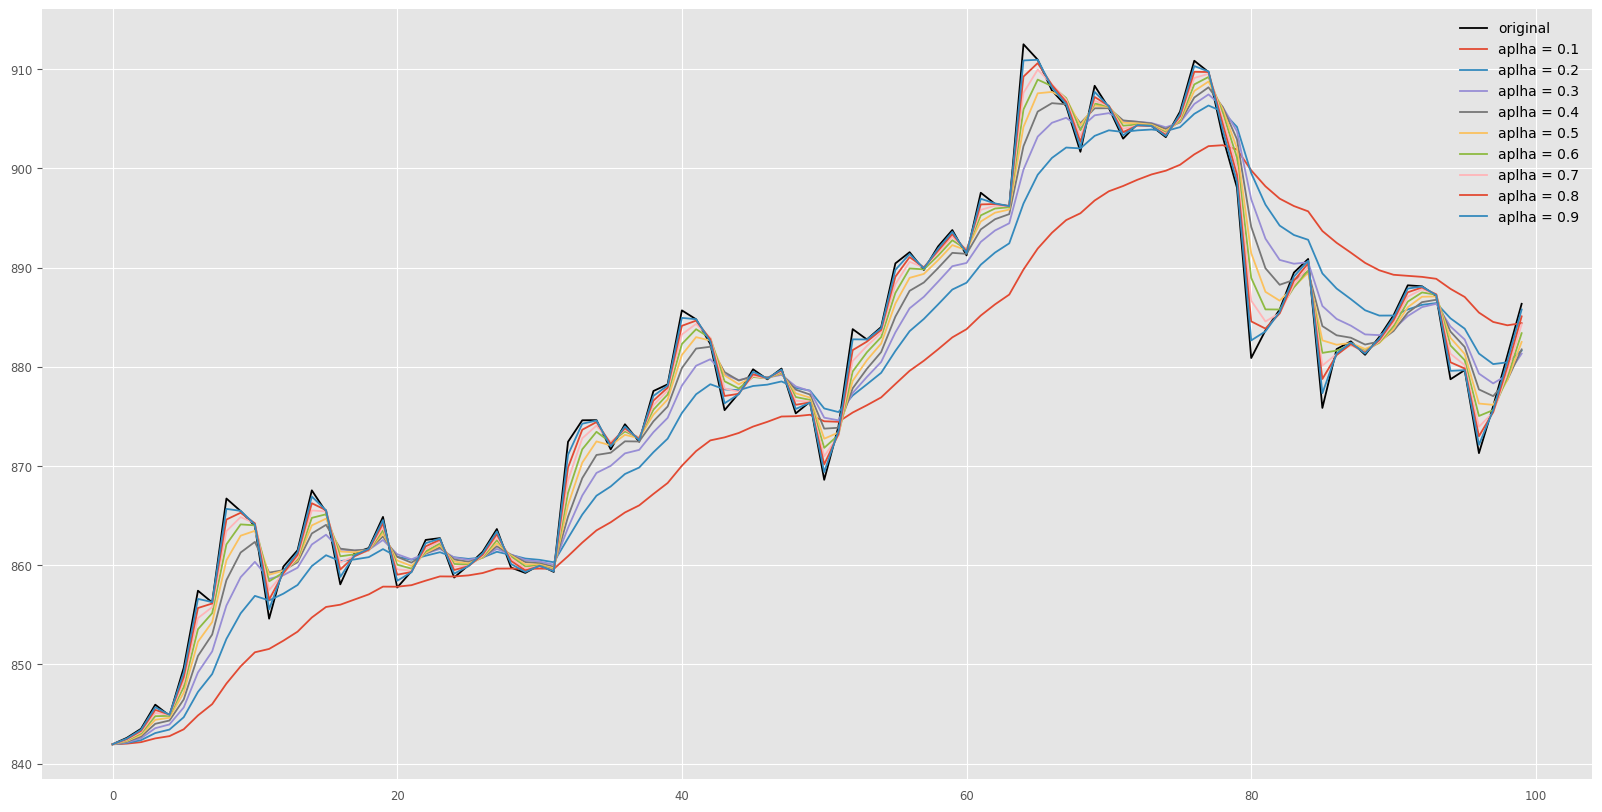

In [6]:
from smoothing import smooth

gold_ts = TimeSeries.from_dataframe(ts)[0:100]
plt.plot(range(0,100), gold_ts.values(), label=f"original", color="black")
for i in range (1,10):
    alpha = i / 10
    smoothed = smooth(gold_ts, alpha)
    plt.plot(range(0,100), smoothed.values(), label=f"aplha = {alpha}")


plt.legend(loc="upper right")
plt.show()

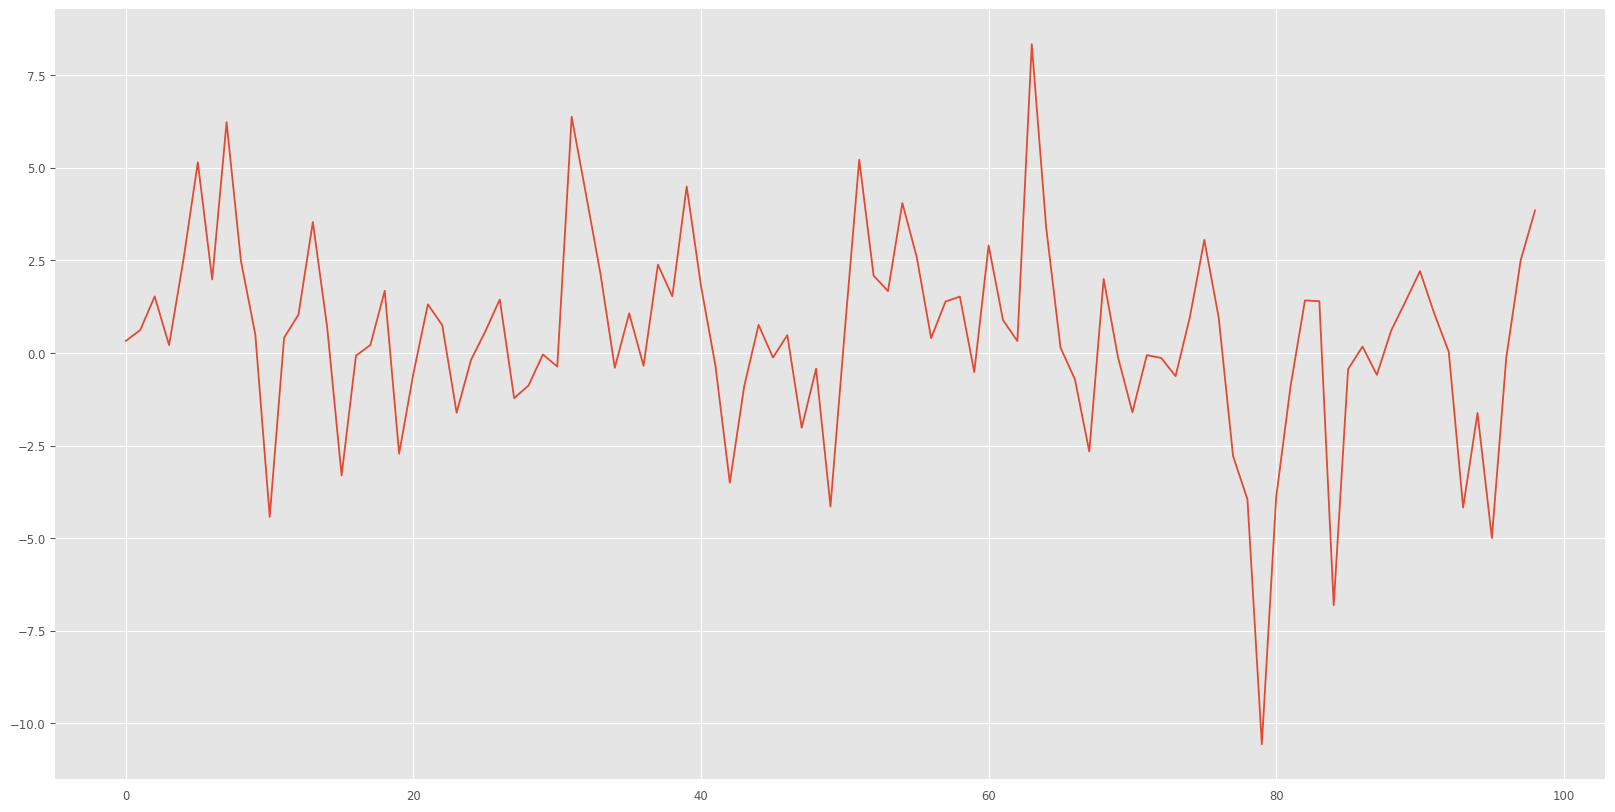

In [9]:
smoothed_diff = smooth(gold_ts, alpha=0.5).diff().values()
plt.plot(range(0,99), smoothed_diff, label=f"aplha = {alpha}, diff = 1")

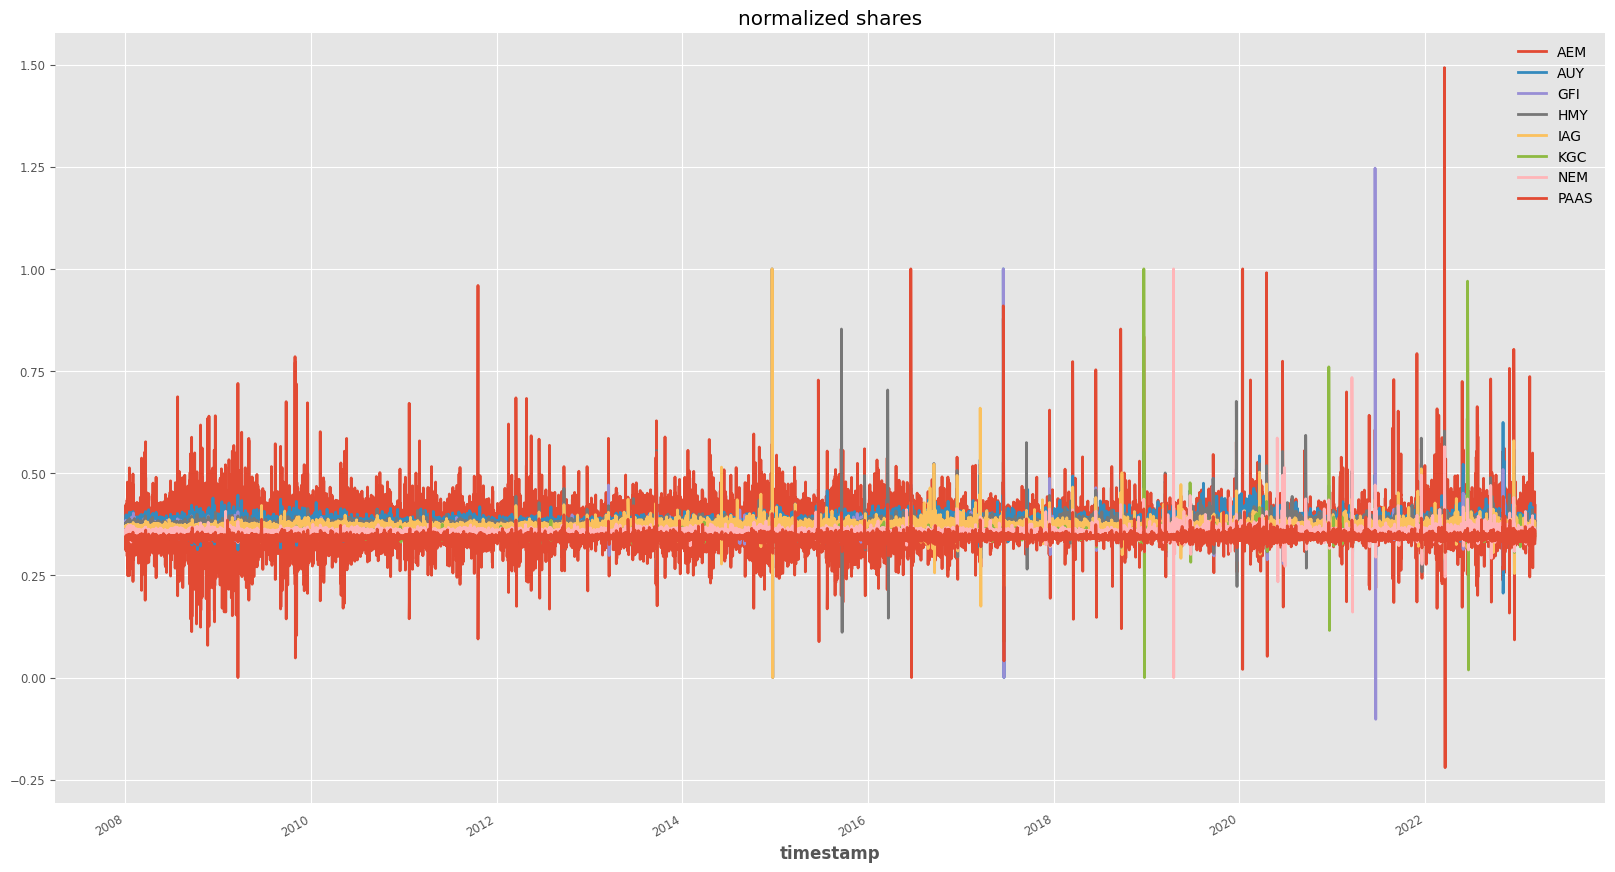

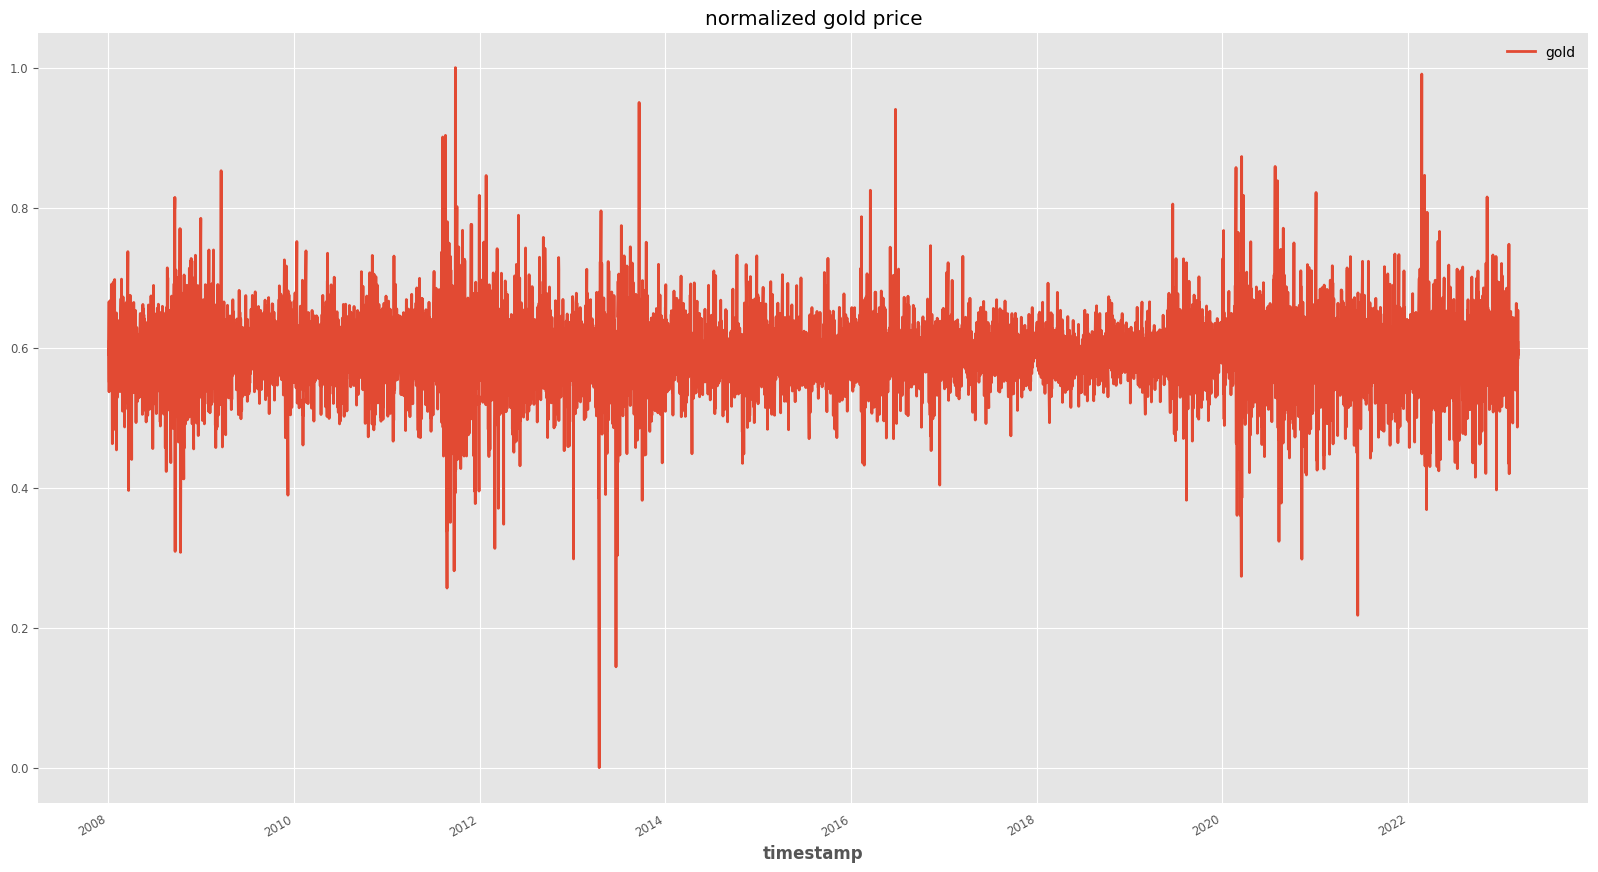

In [5]:
for idx, ticker in enumerate(ds.original.used_tickers):
    ds.covariates.series[idx][CONST.FEATURES.SHARES].plot(label=ticker)

plt.title("normalized shares")
plt.show()


ds.covariates.series[0][CONST.FEATURES.GOLD_PRICE].plot(label="gold")
plt.title("normalized gold price")
plt.show()

In [8]:
import darts.utils.statistics as statistics
# Stationary 
stats_df = pd.DataFrame({ CONST.FEATURES.PRICE: [], f"normalized {CONST.FEATURES.PRICE}": [], f" normalized {CONST.FEATURES.SHARES}": []})
p_threshold = 0.05
def test_stationarity(timeseries: TimeSeries):
    return statistics.stationarity_test_adf(timeseries)[1]

for idx,ticker in enumerate(ds.original.used_tickers):
    price_stationarity = test_stationarity(ds.original.train[idx][CONST.FEATURES.PRICE])
    normalized_price_stationarity = test_stationarity(ds.transformed.train[idx][CONST.FEATURES.PRICE])
    shares_stationarity = test_stationarity(ds.covariances.train[idx][CONST.FEATURES.SHARES])
    stats_df.loc[ticker] = [price_stationarity,normalized_price_stationarity,shares_stationarity]

print(stats_df)
print(stats_df < p_threshold)

         price  normalized price   normalized shares
AEM   0.046790               0.0                 0.0
AUY   0.428439               0.0                 0.0
GFI   0.371473               0.0                 0.0
HMY   0.388207               0.0                 0.0
IAG   0.630505               0.0                 0.0
KGC   0.262822               0.0                 0.0
NEM   0.298614               0.0                 0.0
PAAS  0.082010               0.0                 0.0
      price  normalized price   normalized shares
AEM    True              True                True
AUY   False              True                True
GFI   False              True                True
HMY   False              True                True
IAG   False              True                True
KGC   False              True                True
NEM   False              True                True
PAAS  False              True                True


In [10]:
sns.set_style("whitegrid")
stocks_dict = {}
for idx,ticker in enumerate(CONST.TICKERS):
    stocks_dict[ticker] = ds.transformed.train[idx].pd_series()

stocks_df = pd.DataFrame(stocks_dict)

In [12]:
correlations = stocks_df.corrwith(ds.covariances.series[0][CONST.FEATURES.GOLD_PRICE].pd_series())
plt.figure("Stocks corr with gold price")
sns.heatmap(correlations, annot=True, cmap="summer")
plt.show()

IndexError: Inconsistent shape between the condition and the input (got (8, 1) and (8,))

<Figure size 2000x1000 with 0 Axes>